## Introduction
In this notebook you will download and preprocess the data for the segmentation task for cardiac mri images:<br />
The data is provided by the medical segmentation decathlon (http://medicaldecathlon.com/)<br /> (Data License: https://creativecommons.org/licenses/by-sa/4.0/)<br />

You can directly download the cardiac MRIs and segmentation maps from: <br />
https://drive.google.com/file/d/1wEB2I6S6tQBVEPxir8cA5kFB8gTQadYY/view?usp=sharing

## Imports:
* Pathlib for easy path handling
* nibabel as the files are provided in the NIfTI format
* numpy for data saving and processing
* matplotlib for plotting
* tqdm for nice progressing bars

In [1]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


To work with segmentation images and masks in an organized way, we first define the data access paths using `pathlib.Path`. Since the notebook is executed from the `notebooks/` folder, we need to move up one level (`..`) and enter the `data/Task02_Heart/` directory.

Next, we create two main paths:
- `root`: folder containing the training images (`imagesTr`).
- `label`: folder containing the corresponding segmentation masks (`labelsTr`).

In [2]:
root = Path("../data/Task02_Heart/imagesTr/")
label = Path("/path/to/Task02_Heart/labelsTr/")

To easily switch between images and their corresponding masks, we define the following function:

In [22]:
def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories within the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object


This function takes a path pointing to an image and automatically returns the corresponding mask path by simply replacing the `imagesTr` directory with `labelsTr`.

Afterward, we select a specific sample:
- We use `glob("la*")` to search for files whose names start with "la" within `imagesTr`.
- We select the first file found as `sample_path`.
- We apply the `change_img_to_label_path(sample_path)` function to obtain the corresponding mask path (`sample_path_label`).

This process allows us to easily obtain an **image–mask pair** for exploration or preprocessing, ensuring that we always work with properly matched data.

In [23]:
sample_path = list(root.glob("la*"))[0]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

In [24]:
sample_path, sample_path_label

(WindowsPath('../data/Task02_Heart/imagesTr/la_003.nii.gz'),
 WindowsPath('../data/Task02_Heart/labelsTr/la_003.nii.gz'))

Once we have selected a sample, we load both the MRI volume and its segmentation mask using the `nibabel` library, which is specifically designed for handling medical imaging data in NIfTI format.

In [25]:
#`nib.load(path)`: Loads a NIfTI file as a Nifti1Image object.
data = nib.load(sample_path)
label = nib.load(sample_path_label)

#`get_fdata()`: Extracts the voxel data as a NumPy array.
mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)  #Converts the mask to unsigned 8-bit integers, as class labels should not be treated as floating points.

In [26]:
#`nib.aff2axcodes(data.affine)`: Displays the spatial orientation of the image volume.
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

To better understand the 3D structure of the MRI volume and its corresponding segmentation mask, we use the `celluloid` library to create a simple animation.

`celluloid` allows us to record and animate multiple plots generated with Matplotlib, making it an excellent tool for visualizing how the mask aligns with the anatomical structures across different slices.

In this case:
- A figure is initialized and a `Camera` object is created to capture each frame.
- We loop through all sagittal slices (along the Z-axis) of the MRI volume.
- For each slice, the MRI image is displayed using a grayscale colormap (`bone`).
- The segmentation mask is overlaid with partial transparency (`alpha=0.5`) using a different colormap (`autumn`).
- The camera takes a snapshot of each slice.

Finally, an animation is created by stitching all frames together, providing a dynamic view through the entire volume and its segmentation.

In [27]:
from celluloid import Camera
from IPython.display import HTML

<IPython.core.display.Javascript object>


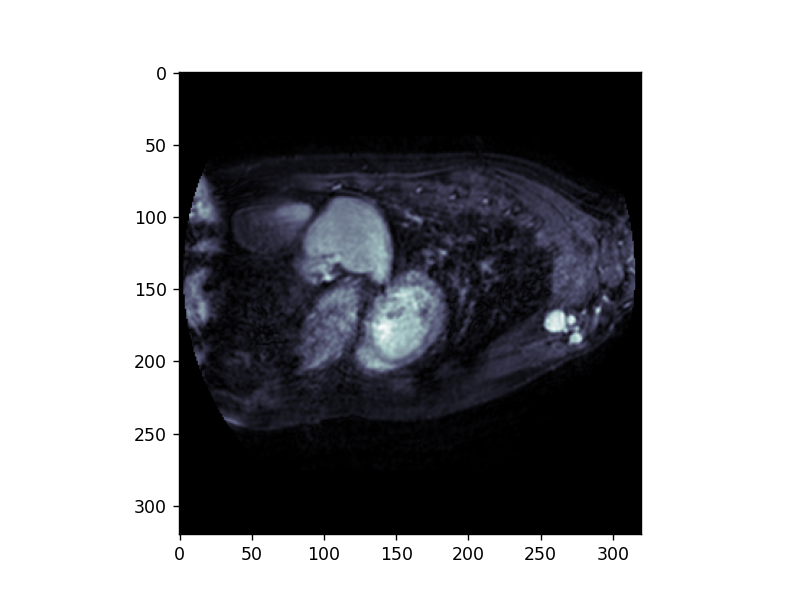

In [28]:
fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

for i in range(mri.shape[2]):  # Sagital view
    plt.imshow(mri[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    # plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # Create the animation




In [29]:
HTML(animation.to_html5_video())  # convert the animation to a video


C:\Users\demonki\anaconda3\envs\pytorchenv\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\demonki\anaconda3\envs\pytorchenv\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


## Preprocessing: Normalization and Standardization

We start by preparing the MRI volumes for model training through normalization and standardization.

**1. Z-Normalization**  
First, we apply Z-normalization to the full 3D volume:

$$X_n = \frac{X - \mu}{\sigma}$$

where:
- \( X \) is the original volume,
- \( \mu \) is the mean voxel intensity across the entire volume,
- \( \sigma \) is the standard deviation of voxel intensities.

This step ensures that the intensity distribution has zero mean and unit variance, improving the model's convergence during training.

**2. Standardization to [0, 1] range**  
After normalization, we further standardize the data to the \([0, 1]\) range:

$$X_s = \frac{X_n - \min(X_n)}{\max(X_n) - \min(X_n)}$$

This transformation rescales the data, making it easier for the model to process inputs within a consistent range.

---

### Helper Functions

- `normalize(full_volume)`:  
  Performs Z-normalization over the entire 3D subject by subtracting the mean and dividing by the standard deviation.

- `standardize(normalized_data)`:  
  Rescales the normalized volume so that the minimum value becomes 0 and the maximum value becomes 1.

---

These steps are essential to homogenize the input data across all subjects, leading to better stability and performance during model training.


In [3]:
# Helper functions for normalization and standardization
def normalize(full_volume):
    """
    Z-Normalization of the whole subject
    """
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized_data):
    """
    Standardize the normalized data into the 0-1 range
    """
    standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized_data


## Preprocessing: Volume to Slice Preparation

All MRI volumes and their corresponding masks are preprocessed as follows: each subject is loaded, its orientation is verified, and 32 pixels are cropped from the top, bottom, front, and back to remove unnecessary background. The cropped volume is then normalized (zero mean, unit variance) and standardized (scaled to [0, 1]). Subjects are divided into training (first 17) and validation sets based on their index. Finally, each 2D slice and its corresponding mask are saved as separate `.npy` files in an organized folder structure (`Preprocessed/train/` or `Preprocessed/val/`) to optimize data loading during training.


In [31]:
all_files = list(root.glob("la*"))  # Get all subjects
len(all_files)

20

In [32]:
save_root = Path("../data/Preprocessed")

for counter, path_to_mri_data in enumerate(tqdm(all_files)):
    
    path_to_label = change_img_to_label_path(path_to_mri_data)
    
    mri = nib.load(path_to_mri_data)
    assert nib.aff2axcodes(mri.affine) == ("R", "A", "S")    
    mri_data = mri.get_fdata()
    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)
    
    # Crop volume and label mask. Reduce 32 px from top and 32 px from bottom.
    # Addtionally crop front and back with same size. Dont crop viewing axis
    mri_data = mri_data[32:-32, 32:-32]
    label_data = label_data[32:-32, 32:-32]
    
    # Normalize and standardize the images
    normalized_mri_data = normalize(mri_data)
    standardized_mri_data = standardize(normalized_mri_data)
    
    # Check if train or val data and create corresponding path
    if counter < 17:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)
    
    # Loop over the slices in the full volume and store the images and labels in the data/masks directory
    for i in range(standardized_mri_data.shape[-1]):
        slice = standardized_mri_data[:,:,i]
        mask = label_data[:,:,i]
        slice_path = current_path/"slices"
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)
        
        
    

  0%|          | 0/20 [00:00<?, ?it/s]

## Validate preprocessed data
Now, we can take a look at the stored files and inspect if everything works

In [4]:
path = Path("../data/Preprocessed/train/1/")  # Select a subject


In [5]:
# Choose a file and load slice + mask
file = "50.npy"
slice = np.load(path/"slices"/file)
mask = np.load(path/"masks"/file)

<IPython.core.display.Javascript object>


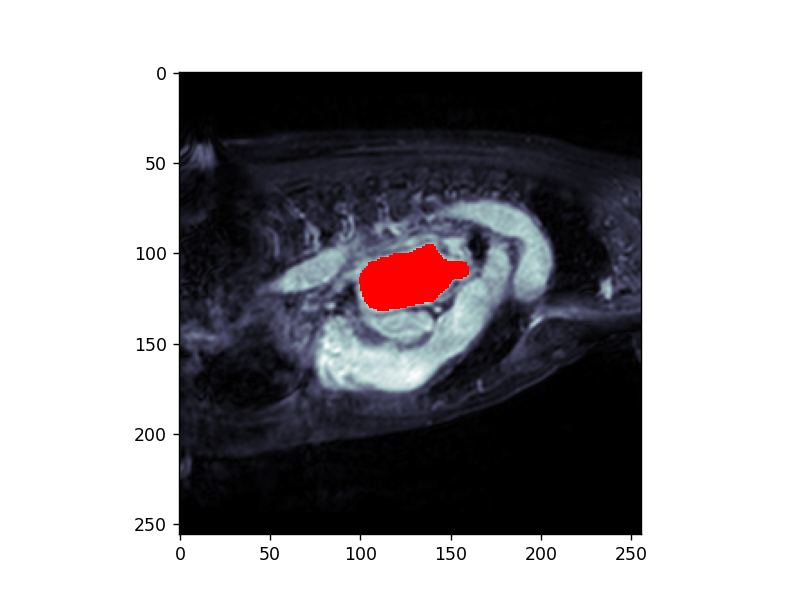

In [6]:
# Plot everything
plt.figure()
plt.imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
plt.imshow(mask_, cmap="autumn")

In [7]:
print(slice.min(), slice.max())

0.0 0.8387631143014908
